# Prepare

In [1]:
# machine learning modules
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import Binarizer

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer

from sklearn.neighbors import KNeighborsRegressor

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from six import StringIO
from IPython.display import Image
from pydot import graph_from_dot_data

In [2]:
# general modules
import pandas as pd
import os
import numpy as np
import seaborn as sns

import time

import pickle
import random

In [3]:
# variables
random_state = 42

temp_path = 'temp'
pckl_train = 'train_data'
pckl_test = 'test_data'

# Import

Import dataframes from pickle files

In [4]:
train_in = open(os.path.join("..",temp_path, pckl_train),'rb')
df_train = pickle.load(train_in)
train_in.close()

In [5]:
test_in = open(os.path.join("..",temp_path, pckl_test),'rb')
df_test = pickle.load(test_in)
test_in.close()

In [6]:
df_train.columns

Index(['order_date', 'ship_date', 'ship_mode', 'customer_id', 'customer_name',
       'segment', 'city', 'state', 'country', 'postal_code', 'market',
       'region', 'product_id', 'category', 'sub-category', 'product_name',
       'sales', 'quantity', 'discount', 'profit', 'shipping_cost',
       'order_priority', 'returned', 'ship_delay', 'delayed'],
      dtype='object')

In [7]:
df_train.head()

,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,country,postal_code,...,product_name,sales,quantity,discount,profit,shipping_cost,order_priority,returned,ship_delay,delayed
index,,,,,,,,,,,,,,,,,,,,,
27507,2012-12-27,2012-12-31,Standard Class,SP-20860,a7d03c30d416fc5f7d695b495884fdd7,Corporate,Murfreesboro,Tennessee,United States,37130.0,...,SanDisk Ultra 16 GB MicroSDHC Class 10 Memory ...,72.744,7,0.2,-12.7302,6.720,Medium,No,4,True
35511,2014-12-25,2015-01-01,Standard Class,JD-15895,1b2850c124acd1bc24237b4b5228b65e,Corporate,Oosterhout,North Brabant,Netherlands,NaN,...,"Smead File Folder Labels, Adjustable",23.730,7,0.5,-21.0000,3.430,Low,No,7,True
9172,2012-05-08,2012-05-11,Second Class,AB-10600,6acab08bb2b385c8569adfd24730ee01,Corporate,Phnom Penh,Phnom Penh,Cambodia,NaN,...,"Dania Corner Shelving, Pine",617.100,5,0.0,172.6500,36.380,Medium,No,3,False
31366,2011-06-30,2011-07-02,Second Class,GH-14410,1528a0a296f3ecf500753855ea9a21a5,Home Office,Lima,Lima (city),Peru,NaN,...,"Hon Bag Chairs, Red",54.180,3,0.4,-32.5200,4.919,Medium,Yes,2,False
24465,2013-06-23,2013-06-26,First Class,KW-16435,648a7c6f93ee0f453ee1378466a84ff8,Consumer,London,England,United Kingdom,NaN,...,"Fellowes Box, Wire Frame",50.625,3,0.1,20.2050,8.570,Medium,No,3,False


# Transform

## Creating features

Order date to month

In [8]:
df_train["order_month"] = pd.DatetimeIndex(df_train["order_date"]).month
df_test["order_month"] = pd.DatetimeIndex(df_test["order_date"]).month

In [9]:
df_train[["order_date","order_month"]].head()

,order_date,order_month
index,,
27507,2012-12-27,12
35511,2014-12-25,12
9172,2012-05-08,5
31366,2011-06-30,6
24465,2013-06-23,6


## Feature selection

In [10]:
target_col = "delayed"

In [11]:
num_cols = ["sales", "quantity", "profit", "shipping_cost"]
std_cols = ["discount"]

nomi_cols = ["order_month", "segment", "market", "category"]
ordi_cols = ["ship_mode", "order_priority"]


bin_cols = ["returned"]

unused_cols = ["order_date", "ship_date", "customer_id", "customer_name", "city", "state" ,"country", "postal_code", "region", "product_id",
               "sub-category", "product_name"]



In [12]:
# check column count

used_cols_len = len(num_cols)+len(nomi_cols)+len(ordi_cols)+len(bin_cols)+len(unused_cols)+len(std_cols)+1

print("Total cols:", len(df_train.columns))
print("Considered cols:", used_cols_len)

Total cols: 26
Considered cols: 25


# Sampling - for debugging only

In [13]:
#df_train = df_train.sample(n=3000)
#df_test = df_train.sample(n=1000)

In [14]:
len(df_train)

38471

## X y split

In [15]:
def split_x_y(df):
    y = np.array(df[target_col])
    return df, y

In [16]:
X_train, y_train = split_x_y(df_train)

In [17]:
X_test, y_test = split_x_y(df_test)

## Pipeline

In [18]:
ordinal_categories = [
    ["Standard Class", "Second Class", "First Class", "Same Day"],
    ["Low", "Medium", "High", "Critical"]
]

In [19]:
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)

In [20]:
std_pipeline = Pipeline([
    ("simple_imp", SimpleImputer())
])

In [21]:
num_pipeline = Pipeline([
    ("simple_imp", SimpleImputer()),
    #("pol", PolynomialFeatures()),
])

In [22]:
nomi_pipeline = Pipeline([
    ("one_hot", OneHotEncoder()),
])

In [23]:
bin_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(sparse=False))
])

In [24]:
# complex transform pipeline includes numeric + binary features
transform_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("nomi", nomi_pipeline, nomi_cols),
    ("ordi", ordinal_encoder, ordi_cols),
    ("bin", bin_pipeline, bin_cols),
    ("std", std_pipeline, std_cols)
])

In [25]:
# simple transform pipeline contains only categorical features
simple_transform_pipeline = ColumnTransformer([
    ("nomi", nomi_pipeline, nomi_cols),
    ("ordi", ordinal_encoder, ordi_cols),
])

---


## KNearest

First try with "complex" pipeline and 8 neighbors 

In [26]:
regression_pipeline = Pipeline([
    ("transform", transform_pipeline),
    ("knearest", KNeighborsRegressor(n_neighbors=8)),
])


In [27]:
model = regression_pipeline.fit(X_train, y_train)
print("Score: ", model.score(X_train, y_train))

Score:  0.5434041852847138


In [28]:
model = regression_pipeline.fit(X_train, y_train)
print("Score: ", model.score(X_test, y_test))

Score:  0.41420299585022635


Try with "simple" pipeline and 8 neighbors

In [29]:
regression_pipeline2 = Pipeline([
    ("transform", simple_transform_pipeline),
    ("knearest", KNeighborsRegressor(n_neighbors=8)),
])

In [30]:
model2 = regression_pipeline2.fit(X_train, y_train)
model2.score(X_train, y_train)

0.825198359432352

In [31]:
model2 = regression_pipeline2.fit(X_train, y_train)
model2.score(X_test, y_test)

0.7866715534626578

### Hyperparameter tuning

In [32]:
# complex transformation
X_train_compl = transform_pipeline.fit_transform(X_train)
X_test_compl = transform_pipeline.fit_transform(X_test)

In [33]:
# simple transformation
X_train_simple = simple_transform_pipeline.fit_transform(X_train)
X_test_simple = simple_transform_pipeline.fit_transform(X_test)

In [34]:
k_n = []
k_train_simple = [] 
k_test_simple = []
k_train_complex = [] 
k_test_complex = []

In [35]:
def k_test_model(n_neighbors):
    
    k_n.append(n_neighbors)
    
    # complex
    model_complex = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X_train_compl, y_train)
    train_score = model_complex.score(X_train_compl, y_train)
    test_score = model_complex.score(X_test_compl, y_test)
    
    k_train_complex.append(train_score)
    k_test_complex.append(test_score)
    
    # simple
    model_simple = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X_train_simple, y_train)
    train_score = model_simple.score(X_train_simple, y_train)
    test_score = model_simple.score(X_test_simple, y_test)
    
    k_train_simple.append(train_score)
    k_test_simple.append(test_score)

In [36]:
# loop through hyperparameter (n neighbors)
test_range = 12

start_time = time.time()

for i in range(test_range):
    k_test_model(i+1)
    
end_time = time.time()

print("Duration: ", end_time - start_time)

Duration:  1334.3797307014465


In [37]:
k_result = pd.DataFrame()
k_result.index = k_n
k_result["Score simple train"] = k_train_simple
k_result["Score simple test"] = k_test_simple
k_result["Score complex train"] = k_train_complex
k_result["Score complex test"] = k_test_complex
k_result


,Score simple train,Score simple test,Score complex train,Score complex test
1,0.740182,0.666912,1.000000,0.031180
2,0.806486,0.740514,0.759104,0.265595
3,0.825162,0.765326,0.672381,0.347872
4,0.829284,0.772905,0.625866,0.381392
5,0.829551,0.778486,0.595835,0.395256
6,0.829550,0.785274,0.574810,0.404352
7,0.827444,0.786179,0.557655,0.409513
8,0.825198,0.786672,0.543404,0.414203
9,0.824201,0.787488,0.533006,0.419513
10,0.821521,0.786577,0.523176,0.418651


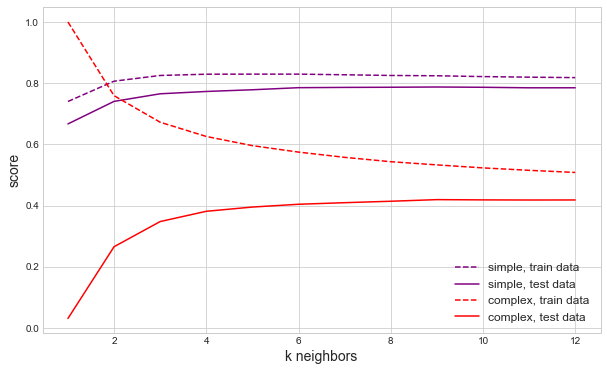

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,6))

plt.plot(k_n, k_train_simple, color="purple", label="simple, train data", linestyle="--")
plt.plot(k_n, k_test_simple, color="purple", label="simple, test data")

plt.plot(k_n, k_train_complex, color="red", label="complex, train data", linestyle="--")
plt.plot(k_n, k_test_complex, color="red", label="complex, test data")

plt.xlabel('k neighbors', size=14)
plt.ylabel('score', size=14)

plt.legend(fontsize=12)


In [39]:
import winsound
winsound.Beep(550,1000)

---

## Decision tree

First try with simple transform pipeline (cat features) and depth of 3

In [40]:
decision_pipeline = Pipeline([
    ("transform", simple_transform_pipeline),
    ("dtree", DecisionTreeClassifier(max_depth=10)),
])

In [41]:
model = decision_pipeline.fit(X_train, y_train)

In [42]:
print("Score: ", model.score(X_train, y_train))

Score:  0.9438278183566843


In [43]:
print("Score: ", model.score(X_test, y_test))

Score:  0.9393325015595758


Second try with simple transform pipeline (incl num features) and depth of 3

In [44]:
decision_pipeline = Pipeline([
    ("transform", transform_pipeline),
    ("dtree", DecisionTreeClassifier(max_depth=10)),
])

In [45]:
model = decision_pipeline.fit(X_train, y_train)

In [46]:
print("Score: ", model.score(X_train, y_train))

Score:  0.9455174027189311


In [47]:
print("Score: ", model.score(X_test, y_test))

Score:  0.936837180286962


### Hyperparameter tuning

In [48]:
d_n = []
d_train_simple = []
d_test_simple = []
d_train_complex = []
d_test_complex = []

In [49]:
def d_test_model(max_depth):
    
    d_n.append(max_depth)
    
    # simple
    model = DecisionTreeClassifier(max_depth=max_depth).fit(X_train_simple, y_train)
    train_score = model.score(X_train_simple, y_train)
    test_score = model.score(X_test_simple, y_test)
    
    d_train_simple.append(train_score)
    d_test_simple.append(test_score)

    # complex
    model = DecisionTreeClassifier(max_depth=max_depth).fit(X_train_compl, y_train)
    train_score = model.score(X_train_compl, y_train)
    test_score = model.score(X_test_compl, y_test)
    
    d_train_complex.append(train_score)
    d_test_complex.append(test_score)
    

In [50]:
start_time = time.time()

for i in range(15):
    d_test_model(i+1)
    
end_time = time.time()

print("Duration: ", end_time - start_time)

Duration:  1.74226975440979


In [51]:
d_result = pd.DataFrame()
d_result.index = d_n
d_result["Score train simple"] = d_train_simple
d_result["Score test simple"] = d_test_simple
d_result["Score train complex"] = d_train_complex
d_result["Score test complex"] = d_test_complex

d_result

,Score train simple,Score test simple,Score train complex,Score test complex
1,0.919212,0.915471,0.919212,0.915471
2,0.919212,0.915471,0.919212,0.915471
3,0.940189,0.939333,0.940189,0.939333
4,0.940189,0.939333,0.940189,0.939333
5,0.940579,0.939410,0.940189,0.939333
6,0.941098,0.939566,0.941021,0.938865
7,0.941306,0.939566,0.941384,0.938631
8,0.941878,0.939255,0.942684,0.937851
9,0.943126,0.938709,0.943958,0.937539
10,0.943828,0.939333,0.945517,0.936759


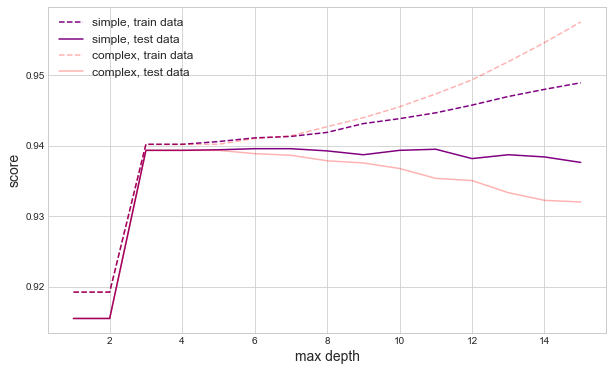

In [52]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,6))

plt.plot(d_n, d_train_simple, color="purple", linestyle="--", label="simple, train data")
plt.plot(d_n, d_test_simple, color="purple", label="simple, test data")

plt.plot(d_n, d_train_complex, color="red", linestyle="--", label="complex, train data", alpha=0.3)
plt.plot(d_n, d_test_complex, color="red", label="complex, test data", alpha=0.3)

plt.xlabel('max depth', size=14)
plt.ylabel('score', size=14)

plt.legend(fontsize=12)

### Visualization

In [53]:
def split_x_y(df, features):
    df = df.dropna()
    y = df[target_col]
    X = df.loc[: , features]
    X = pd.get_dummies(X)
    return X, y

In [54]:
feature_selection = nomi_cols + ordi_cols

In [55]:
X_train_g, y_train_g = split_x_y(df_train, feature_selection)

In [56]:
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train_g, y_train_g)

DecisionTreeClassifier(max_depth=4)

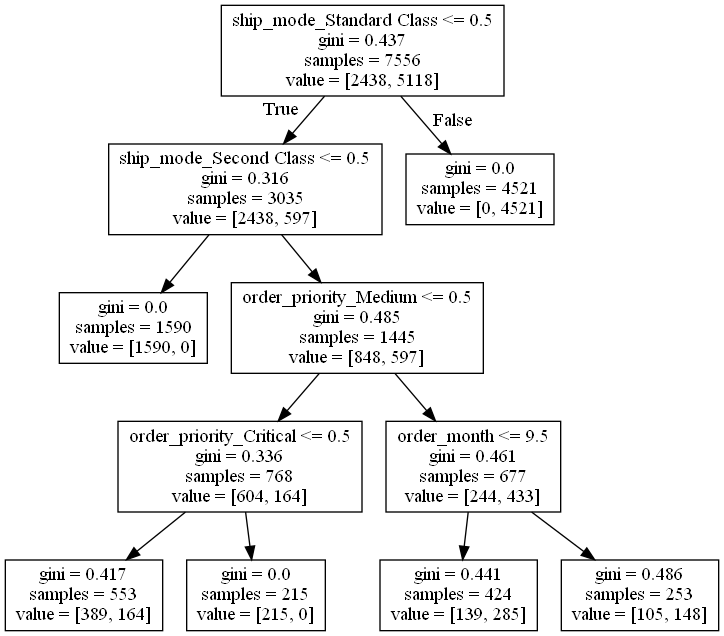

In [58]:
dot_data = StringIO()
export_graphviz(model, out_file=dot_data, feature_names=X_train_g.columns)
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

# Prediction

In [59]:
decision_pipeline = Pipeline([
    ("transform", simple_transform_pipeline),
    ("dtree", DecisionTreeClassifier(max_depth=4)),
])

model = decision_pipeline.fit(X_train, y_train)

In [60]:
y_train_predict = model.predict(X_test)

In [61]:
X_test["prediction"] = y_train_predict

In [62]:
X_test

,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,country,postal_code,...,quantity,discount,profit,shipping_cost,order_priority,returned,ship_delay,delayed,order_month,prediction
index,,,,,,,,,,,,,,,,,,,,,
30040,2012-09-05,2012-09-11,Standard Class,CA-12055,d7f40cbb6597f62d85534ef6342c695e,Home Office,Houston,Texas,United States,77036.0,...,9,0.2,-14.6880,5.480,Medium,No,6,True,9,True
44906,2014-04-17,2014-04-23,Standard Class,MH-18025,0b13a87bdfb89e5bb4b2c7d188c81a66,Consumer,Hayange,Lorraine,France,NaN,...,1,0.0,4.0500,1.250,Medium,No,6,True,4,True
27274,2014-09-01,2014-09-06,Second Class,SS-20410,27ea858c3a7e3c037df97c0e1e7b8d5f,Consumer,Maracay,Aragua,Venezuela,NaN,...,2,0.4,-17.8480,6.841,Medium,No,5,True,9,True
35047,2013-11-11,2013-11-15,Second Class,LT-16765,92d453d65fa6b31840bc146955c2f8c9,Consumer,Bikaner,Rajasthan,India,NaN,...,3,0.0,2.4300,3.570,Medium,No,4,True,11,True
45715,2014-10-28,2014-10-31,Second Class,MA-17560,92adf7ff67aa85d6a74afadb0c095427,Home Office,Chicago,Illinois,United States,60610.0,...,3,0.2,2.2050,1.110,Medium,No,3,False,10,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25018,2011-05-11,2011-05-16,Standard Class,PG-18895,4c63c9a8552f33c37ca42d8227bd8bf3,Consumer,Fort Worth,Texas,United States,76106.0,...,1,0.2,6.2995,8.210,Medium,No,5,True,5,True
16992,2012-09-27,2012-09-29,Second Class,SS-20140,ffbcd7803fec65466870f0d49e286497,Corporate,Seattle,Washington,United States,98103.0,...,5,0.0,25.7920,16.360,Critical,No,2,False,9,False
34459,2014-10-24,2014-10-30,Standard Class,JC-16105,d5ed932ed8b86e3d5a97c7f2f746c1e4,Corporate,Rochester,New York,United States,14609.0,...,5,0.0,11.8800,3.760,Low,No,6,True,10,True
